## Limites de Langevin puis Annealed Langevin

In [82]:
import torch
import torch.distributions as dist
import matplotlib.pyplot as plt

In [83]:
torch.set_default_dtype(torch.float32)
def t(x):
    # j'avais des problèmes de type avec les long 
    return torch.as_tensor(x, dtype=torch.get_default_dtype())


In [84]:
def score(distrib,x):
    x = x.clone().detach().requires_grad_(True)
    lp = distrib.log_prob(x)
    score, = torch.autograd.grad(lp.sum(),x) # lp.sum() pour que si x a un batch_size ça marche.
    return score

In [85]:
def Langevin_sampler(prior,score,tau,T,n_chain):
    # score is a fonction of x
    X = prior.sample((n_chain,))
    U = dist.MultivariateNormal(loc = t([0,0]),covariance_matrix=torch.eye(2))
    for _ in range(T): 
        X = X +  tau * score(X) + torch.sqrt(t(2*tau)) * U.sample((n_chain,))
    return X    


### Langevin sur des Mixture de Gaussiennes

#### 1) Cas basique

Dans ce cas on créer deux gaussiennes avec des variances qui ne sont pas trop faible mais l'une qui a un poids dominant par rapport à l'autre. 
On observe dans ce qui suit que la méthode de sampling Langevin n'arrive pas à retrouver la répartition entre les deux gaussiennes. Il génère environ autant d'écahntillons de l'un que de l'autre.

In [86]:
mean = torch.stack(
    [
    t([-4,4]), # mean Gauss 1 
    t([4,-4])  # mean Gauss 2 
    ]
    ,dim = 0
)

cov = torch.stack(
    [
        torch.eye(2), # cov 
        torch.eye(2)  #cov 2
    ],
    dim = 0
)

gaussians = dist.MultivariateNormal(loc = mean,covariance_matrix=cov)


In [87]:
weights = dist.Categorical(t([0.1,0.9]))
mixture = dist.MixtureSameFamily(weights,gaussians)


In [88]:
prior_mean = t([0,0])
prior_var = torch.eye(2)
prior_distrib = dist.MultivariateNormal(prior_mean,covariance_matrix=prior_var)


In [89]:
n_chain = 5000
langevin_samples = Langevin_sampler(prior=prior_distrib,score = lambda x : score(mixture,x),tau = 0.02,T=10000,n_chain=n_chain)
true_samples = mixture.sample((n_chain,))

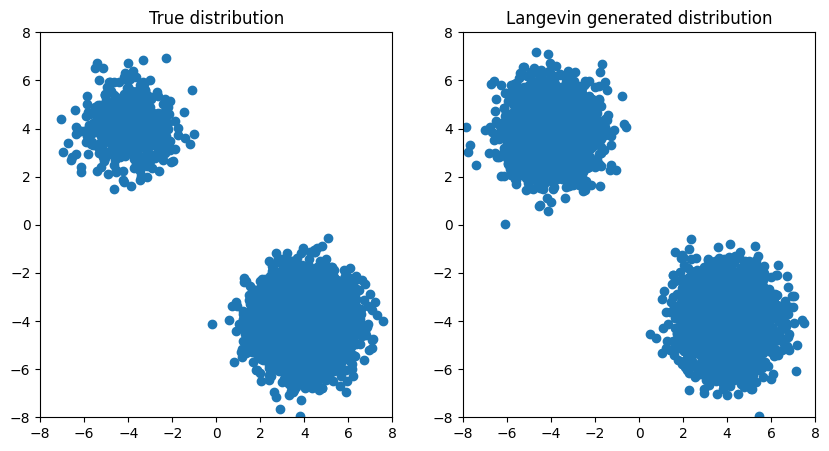

In [90]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.scatter(true_samples.T[0],true_samples.T[1])
plt.title("True distribution")
plt.subplot(1,2,2)
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.title('Langevin generated distribution')
plt.scatter(langevin_samples.T[0],langevin_samples.T[1])
plt.show()

### 2) Petites variances (distribution modale)

On observe dans ce cas que la méthode de sampling n'arrive même pas à atteindre ce mode.

In [91]:

mean = torch.stack(
    [
    t([-4,4]), # mean Gauss 1 
    t([4,-4])  # mean Gauss 2 
    ]
    ,dim = 0
)

cov = torch.stack(
    [
        torch.eye(2)/10, # cov 
        torch.eye(2)  #cov 2
    ],
    dim = 0
)

gaussians = dist.MultivariateNormal(loc = mean,covariance_matrix=cov)
weights = dist.Categorical(t([0.1,0.9]))
mixture = dist.MixtureSameFamily(weights,gaussians)



In [92]:
prior_mean = t([0,0])
prior_var = torch.eye(2)
prior_distrib = dist.MultivariateNormal(prior_mean,covariance_matrix=prior_var)

n_chain = 5000
langevin_samples = Langevin_sampler(prior=prior_distrib,score = lambda x : score(mixture,x),tau = 0.02,T=10000,n_chain=n_chain)
true_samples = mixture.sample((n_chain,))

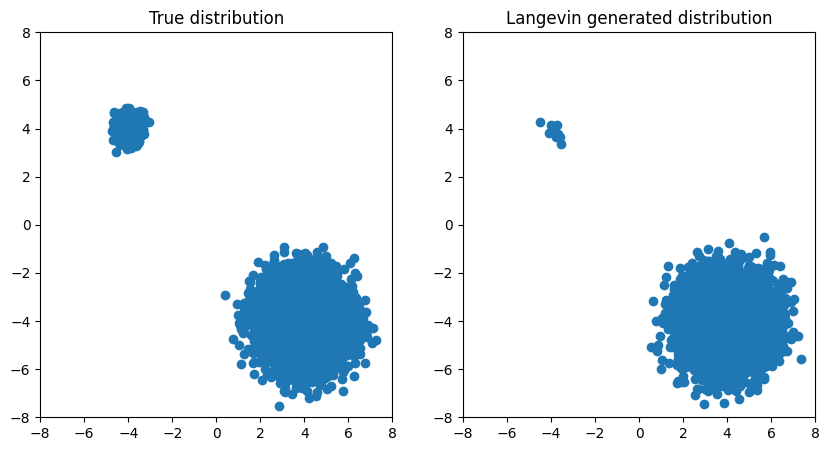

In [93]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.scatter(true_samples.T[0],true_samples.T[1])
plt.title("True distribution")
plt.subplot(1,2,2)
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.title('Langevin generated distribution')
plt.scatter(langevin_samples.T[0],langevin_samples.T[1])
plt.show()

## Annealed Langevin

In [94]:
def annealded_langevin_sampler(prior,noisy_distrib_scores,noise_factor,step_size,T,n_chain):
    X = prior.sample((n_chain,))
    U = dist.MultivariateNormal(loc = t([0,0]),covariance_matrix=torch.eye(2))
    for i in range(len(noisy_distrib_scores)):

        tau = step_size * noise_factor[i]
        for _ in range(T):
            X = X + tau*noisy_distrib_scores[i](X) + torch.sqrt(t(2*tau))*U.sample((n_chain,))
    return X   
def construct_noise(min,max,L):
    return list(torch.linspace(min,max,L))[::-1]


def construct_GMM_noised_distribution(noise_list,loc,cov,weights):
    d = loc.size(-1)
    noised_distribution = []
    for sigma2 in noise_list : 
        g_noised = dist.MultivariateNormal(loc,cov + torch.eye(d)*sigma2)
        noised_distribution.append(dist.MixtureSameFamily(weights,g_noised))
    return noised_distribution

def make_score_fn(d):
    return lambda x: score(d, x)


In [95]:

# paramètres list de bruit`
L = 20 
var_min = 0.01
var_max = 5


noise_list = construct_noise(0.01,5,L)
noised_dist = construct_GMM_noised_distribution(noise_list=noise_list,loc=mean,cov=cov,weights=weights)
noisy_distribution_scores = [make_score_fn(d) for d in noised_dist]

true_distrib = dist.MixtureSameFamily(weights,dist.MultivariateNormal(mean,cov))

prior_mean = t([0,0])
prior_var = torch.eye(2)
prior_distrib = dist.MultivariateNormal(prior_mean,covariance_matrix=prior_var)

n_chain = 5000

A_langevin_samples = annealded_langevin_sampler(prior_distrib,noisy_distribution_scores,noise_list,t(0.2),1000,n_chain)
true_samples = true_distrib.sample((n_chain,))

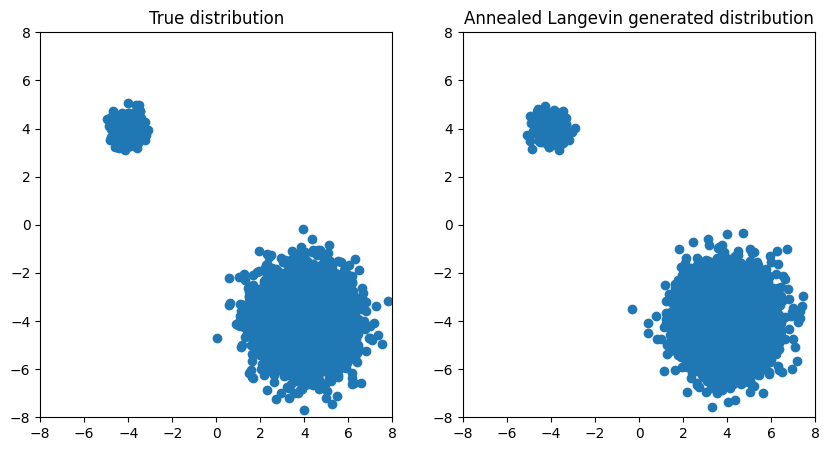

In [96]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.scatter(true_samples.T[0],true_samples.T[1])
plt.title("True distribution")
plt.subplot(1,2,2)
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.title('Annealed Langevin generated distribution')
plt.scatter(A_langevin_samples.T[0],A_langevin_samples.T[1])
plt.show()

#### On test les limites de Annealed Langevin

On met une mixture avec 3 gaussiennes dont une avec une variance très très faible.

Quelques remarques : on remarque assez étonnamment que il suffit d'utiliser 2 niveaux de bruit dans notre cas afin d'avoir des résultats satisfaisant.
Bien sur sigma_min doit Être très faible et sigma_max très élevé mais c'est assez surprenant. Ça veut dire que un bon prior est vraiment quelquechose de puissant.
Il y a un juste milieu à trouver : sigma max ne peut pas être trop grand


In [ ]:
mean = torch.stack(
    [
    t([-4,4]), # mean Gauss 1 
    t([4,-4]),  # mean Gauss 2 
    t([0,0])
    ]
    ,dim = 0
)

cov = torch.stack(
    [
        torch.eye(2)/10, # cov 
        torch.eye(2),  #cov 2
        torch.eye(2)/40
    ],
    dim = 0
)

weights = dist.Categorical(t([0.1,0.6,0.3]))


# paramètres list de bruit`
L = 2
var_min = 0.01
var_max = 5


noise_list = construct_noise(var_min,var_max,L)
noised_dist = construct_GMM_noised_distribution(noise_list=noise_list,loc=mean,cov=cov,weights=weights)
noisy_distribution_scores = [make_score_fn(d) for d in noised_dist]
print(noise_list)
true_distrib = dist.MixtureSameFamily(weights,dist.MultivariateNormal(mean,cov))

prior_mean = t([10,0])
prior_var = torch.eye(2)
prior_distrib = dist.MultivariateNormal(prior_mean,covariance_matrix=prior_var)

n_chain = 5000

A_langevin_samples = annealded_langevin_sampler(prior_distrib,noisy_distribution_scores,noise_list,t(0.2),1000,n_chain)
true_samples = true_distrib.sample((n_chain,))

[tensor(10.), tensor(0.0100)]


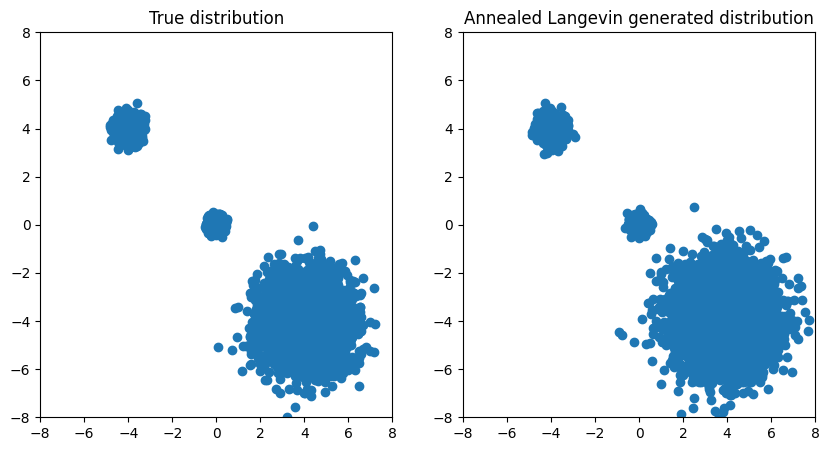

In [98]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.scatter(true_samples.T[0],true_samples.T[1])
plt.title("True distribution")
plt.subplot(1,2,2)
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.title('Annealed Langevin generated distribution')
plt.scatter(A_langevin_samples.T[0],A_langevin_samples.T[1])
plt.show()